# Novelty

In [1]:
from koselleck import *

In [290]:
def do_get_novelty(word,**kwargs):
    return test_novelty(get_historical_semantic_distance_matrix(
            word,
            interpolate=True,
            normalize=True
        ),
        **kwargs
    ).assign(word=word)

def get_novelty(words=None,interpolate=True,by_word=True,progress=False, lim=None, num_proc=1, **y):
    if words is None: words=get_valid_words()
    words=tokenize_fast(words) if type(words)==str else words
    if os.path.exists(FN_NOV_ALL_BYWORD):
        odf=get_all_novelty_scores(by_foote_size=True)
        odf=odf[odf.word.isin(words)]
        if not by_word: odf=odf.groupby(['foote_size','period']).mean().reset_index()
    else:
        if by_word:
            o=pmap(
                do_get_novelty,
                words[:lim],
                progress=progress,
                desc='Calculating novelty for words',
                num_proc=num_proc
            )
            odf=pd.concat(o) if len(o) else pd.DataFrame()
        else:
            distdf=get_historical_semantic_distance_matrix(words,interpolate=interpolate)
            odf=test_novelty(distdf,**y)
        odf['period']=[int(x[:4]) for x in odf.period]
    return odf

In [329]:
get_historical_semantic_distance_matrix('virtue')

,corpus1,corpus2,period1,period2,word,dist_local,dist_local_z,dist_local_perc
6684,bpo,bpo,1755-1760,1750-1755,virtue,0.018727,-2.021380,0.201441
19721,bpo,bpo,1865-1870,1855-1860,virtue,0.024442,-1.902372,0.603847
21498,bpo,bpo,1755-1760,1760-1765,virtue,0.025019,-1.903953,0.577201
23280,bpo,bpo,1760-1765,1750-1755,virtue,0.025564,-1.885471,0.635597
30772,bpo,bpo,1760-1765,1815-1820,virtue,0.027637,-1.838882,1.015572
...,...,...,...,...,...,...,...,...
4638395,bpo,bpo,1930-1935,1825-1830,virtue,0.205427,1.347784,90.238322
4643391,bpo,bpo,1805-1810,1930-1935,virtue,0.205887,1.383932,90.862998
4681832,bpo,bpo,1930-1935,1810-1815,virtue,0.209563,1.421794,91.078020
4704141,bpo,bpo,1825-1830,1925-1930,virtue,0.211829,1.452715,91.380731


AttributeError: 'DataFrame' object has no attribute 'k'

In [291]:
get_novelty('virtue,value',by_word=True)

,period,foote_novelty,foote_size,p_peak,p_trough,word,foote_novelty_z
100,1740,2.692189,4,1.00,1.0,value,-0.525692
101,1745,4.522264,4,0.48,1.0,value,0.135949
102,1750,3.659113,4,0.91,1.0,value,-0.176113
103,1755,3.529320,4,0.91,1.0,value,-0.223038
104,1760,2.949576,4,1.00,1.0,value,-0.432637
...,...,...,...,...,...,...,...
229,1905,8.042206,6,0.57,1.0,virtue,-0.240696
230,1910,10.422168,6,0.02,1.0,virtue,0.176976
231,1915,9.391275,6,0.15,1.0,virtue,-0.003941
232,1920,8.446556,6,0.46,1.0,virtue,-0.169735


In [286]:
# get_novelty('station', by_word=False).query('foote_novelty!=0')

In [287]:
# nov_all_mean=get_novelty(by_word=False)
# nov_all_mean

In [335]:
def get_all_novelty_scores(ifnfn=FN_NOV_ALL_BYWORD,
                           by_foote_size=False, min_foote_size=4, max_foote_size=6):
    global DFALLNOV
    if DFALLNOV is not None:
        odf=DFALLNOV
    elif not os.path.exists(ifnfn):
        print(f'Generating novelty scores, saving to {ifnfn}')
        DFALLNOV = odf = nov_all_byword = get_novelty(by_word=True,progress=True,num_proc=1)
        nov_all_byword.to_pickle(FN_NOV_ALL_BYWORD)
    else:
        print(f'Loading novelty scores from {ifnfn}')
        DFALLNOV=odf=read_df(ifnfn)
        
    odf = odf.query(f'foote_novelty!=0 & {min_foote_size}<=foote_size<={max_foote_size}')
    odf = pd.concat(
        grp.assign(
            foote_novelty_z=(grp.foote_novelty - grp.foote_novelty.mean()) / grp.foote_novelty.std()
        )
        for i,grp in odf.groupby('foote_size')
    )
    if not by_foote_size:
        odf=odf.groupby(['word','period']).mean().drop('foote_size',1).reset_index()
    else:
        odf['foote_size']=odf.foote_size.apply(int)
        
    #odf=odf.query('period<1900')
    return odf
        


In [336]:
get_all_novelty_scores(by_foote_size=True)

,period,foote_novelty,foote_size,p_peak,p_trough,word,foote_novelty_z
90,1765,2.472151,4,1.00,1.00,recollection,-0.605244
91,1770,4.423152,4,0.85,1.00,recollection,0.100116
92,1775,2.624945,4,1.00,1.00,recollection,-0.550003
93,1780,0.746535,4,1.00,0.04,recollection,-1.229119
94,1785,2.954981,4,1.00,1.00,recollection,-0.430683
...,...,...,...,...,...,...,...
224,1905,12.817505,6,0.37,1.00,inference,0.597346
225,1910,12.671342,6,0.41,1.00,inference,0.571695
226,1915,13.574138,6,0.24,1.00,inference,0.730131
227,1920,14.853950,6,0.07,1.00,inference,0.954732


In [337]:
def get_signif_novelty_scores(p_peak=0.05,min_peaks=1):
    odf=get_all_novelty_scores().query(f'p_peak<{p_peak}')
    odf=pd.concat(
        grp.assign(
            word_num_peaks=len(grp[grp.p_peak<p_peak])
        ) for i,grp in odf.groupby('word')
    )
    if min_peaks: odf=odf[odf.word_num_peaks>=min_peaks]
    return odf.sort_values('foote_novelty_z',ascending=False)

In [338]:
get_signif_novelty_scores(
    p_peak=0.05
).groupby('word').mean().sort_values('foote_novelty_z',ascending=False)

,period,foote_novelty,p_peak,p_trough,foote_novelty_z,word_num_peaks
word,,,,,,
suite,1932.5,25.179953,0.007500,1.0,6.743004,2.0
soprano,1935.0,22.742899,0.000000,1.0,6.723391,1.0
string,1935.0,22.344817,0.000000,1.0,6.579469,1.0
sphere,1900.0,34.886402,0.000000,1.0,6.577979,3.0
regent,1822.5,34.014854,0.000000,1.0,6.492959,2.0
...,...,...,...,...,...,...
reason,1755.0,2.956013,0.043333,1.0,-0.888728,1.0
hour,1745.0,2.124452,0.045000,1.0,-0.919948,1.0
world,1742.5,1.822498,0.020000,1.0,-0.947352,2.0


In [339]:
def get_signif_novelty_words(p_peak=0.05,min_peaks=1):
    df=get_all_novelty_scores()
    dfsign=get_signif_novelty_scores(p_peak=p_peak,min_peaks=min_peaks)
    signwset=set(dfsign.word)
    o=[
        w for w in 
        df.groupby('word').mean().sort_values('foote_novelty',ascending=False).index
        if w in signwset
    ]
    print('# all words',len(set(df.word)))
    print('# signif words',len(set(dfsign.word)))
    return o

In [340]:
sign_words = get_all_sign_words(p_peak=0.05)

# all words 6007
# signif words 2273


## Plotting

In [341]:
def get_plot_novelty_figdf(novdf):
    figdf=novdf.sample(frac=1)
    ywl=[
        f'{x} years'
        for x in figdf['foote_size']*5*2
    ]
    ywls=set(ywl)
    ywll=list(reversed(sorted(list(ywls))))
    figdf['year_window']=pd.Categorical(ywl, categories=ywll)
    figdf['glen']=1
    figdf['is_signif']=pd.Categorical(
        [bool(x<0.05) for x in figdf.p_peak],
        categories=[True,False]
    )
    figdf = pd.concat(
        grp.assign(foote_novelty_z=grp.foote_novelty.apply(lambda x: (x-grp.foote_novelty.mean())/grp.foote_novelty.std()))
        for i,grp in figdf.groupby('foote_size')
    )
    return figdf.dropna().sort_values(['year_window','period'])


# @interact
def plot_novelty(
        words=None,
        novdf=None,
        color='factor(year_window)',
        group='factor(year_window)',
        shape='factor(year_window)',
        size='glen',
        max_p_peak=None,
        vnum='v9',
        showdata=False,
        xlab='Date of semantic model',
        ylab='Foote Novelty (standardized)',
        colorlab='Foote matrix width',
        shapelab='Foote matrix width',
        sizelab='Number of significant peaks',
        title='Average novelty score for significant words over time',
        rolling=2,
        min_periods=1,
        min_foote_size=6,
        max_foote_size=6,
        y='foote_novelty',
        ymin=-.1,
        ylim0=0,
        ylim1=20,
        use_ylim=False,
        xlim0=1750,
        xlim1=1900,
        sizemin=.25,
        sizemax=2,
        labsize=6,
        hline='',
        nudge_label_y=1,
        ymin_heatmap=1750,
        combine=False,
        use_color=False,
        h_fig1=4.00,
        h_fig2=4.00,
        nudge_x=3,
        xlab_min=1735,
        add_median=True,
        save=False,
        label_words=False,
        logy=False,
        show_period_labels=True,
        dist_invert_fill=False,
        line_size=0.5,
        label_size=7,
        by_word=False
        ):

    figwords=set(words) if words else {'allwords'}
    if novdf is None:
        if words is None: return
        
        novdf = get_novelty(words,by_word=by_word)
        if not by_word: words=None
        print(f'Computed novelty df of shape {novdf.shape}')
        display(novdf)
        
    figdf=get_plot_novelty_figdf(novdf.query(f'{min_foote_size}<=foote_size<={max_foote_size}'))
    if not len(figdf): return
    if max_p_peak: figdf=figdf[figdf.p_peak<max_p_peak]
    
    
    figdf=figdf.sort_values('period')
#     display(figdf)
    if showdata: display(figdf)
#     print(f'y = {y}')
    fig=start_fig(
        figdf,
        x='period',
        y=y,
        color=color if color else None,
        group=group if group else None,
        figure_size=(8,h_fig1)
    )
    
    if add_median:
        kname='Guides'
        mediandf=pd.DataFrame([{
            'yintercept':figdf[y].median(),
            kname:'Median',
        },
#         {
#             'yintercept':0,
#             kname:'Zero novelty'
#         }
        ])
        fig+=p9.geom_hline(
            p9.aes(yintercept='yintercept',linetype=kname),
            data=mediandf,
            size=.25,
            show_legend=True
        )
        #fig+=p9.geom_text(inherit_aes=False,y=figdf[y].median()+.1,x=xlab_min,size=6,alpha=.8,ha='center',label='Median')
    
            
    fig+=p9.geom_line(size=line_size)
    pntd={}
    if size: pntd['size']=size
    if shape: pntd['shape']=shape
    fig+=p9.geom_point(p9.aes(**pntd))
    # fig+=p9.geom_smooth()
#     fig+=p9.scale_color_distiller()
    
    
    fig+=p9.labs(x=xlab,y=ylab,title=title,color=colorlab,size=sizelab,shape=shapelab)
    if use_ylim: fig+=p9.ylim(ylim0,ylim1)
#     fig+=p9.xlim(xlim0,xlim1)
    fig+=p9.scale_size_continuous(range=(sizemin,sizemax))
    if not use_color: fig+=p9.scale_color_gray(direction=1)# if not use_color else p9.scale_color_distiller(type='qual')
    if hline not in {None,''}:
        fig+=p9.geom_hline(yintercept=hline,linetype='dotted')
#     fig+=p9.geom_smooth(p9.aes(x='year',y=y),inherit_aes=False)

    if words and label_words:
        labeldf=figdf[figdf.is_signif==1]
        grps=[
            grp.sort_values(y).iloc[-1:]
            for i,grp in labeldf.groupby('word')
        ]
        if len(grps):
            labeldf=pd.concat(grps)
            labeldf[y]+=nudge_label_y
            fig+=p9.geom_label(p9.aes(label='word'),color='black',
                               size=label_size,data=labeldf,boxcolor=(0,0,0,0))


    if show_period_labels:
        fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
        fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1750,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1850,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1848,linetype='dotted',alpha=0.5) 
#         fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
#     if False:
        fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
        fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='French Rev. (1789)',x=1789+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Peak semantic change (1815)',x=1815+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
#         fig+=p9.geom_label(label='Revolutions of 1848',x=1848+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    
    
    

    
    
#     fig+=p9.geom_vline(xintercept=1789,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1815,linetype='dotted',alpha=0.5) 
#     fig+=p9.geom_vline(xintercept=1830,linetype='dashed')
    

#     xlim0,xlim1=figdf.year.min()//10*10,figdf.year.max()
    if size=='is_signif':
        fig+=p9.scale_size_manual({True:2,False:.2})
    else:
        fig+=p9.scale_size_continuous(range=[.25,3])
#     fig+=p9.scale_x_continuous(breaks=10)
    fig+=p9.theme_minimal()
    fig+=p9.theme(axis_text_x=p9.element_text(angle=90), text=p9.element_text(size=8))
#     if not use_ylim:
#         ylim0=figdf[y].dropna().min()
#         ylim1=figdf[y].dropna().max()
    if logy: fig+=p9.scale_y_log10(limits=[ylim0,ylim1])
        
    
    
    
    #fig+=p9.scale_fill_gray()
    fig+=p9.scale_x_continuous(
        minor_breaks=list(range(xlim0//5*5,(xlim1//5*5)+5,5)),
        limits=[xlim0,xlim1]
    )
#     fig+=p9.xlim(xlim0,xlim1)
    wkey=''
    if words: wkey=words.replace(' ','') if type(words)==str else '-'.join(words)
    ofn=f'''fig.footenov.{vnum}.{wkey+'.' if wkey else ''}{'cmbo.' if combine else ''}png'''
    ofnfn=os.path.join(PATH_FIGS,ofn)

    if combine:
        yymin1=figdf.period.min()
        yymax1=figdf.period.max()
        figdm=plot_historical_semantic_distance_matrix(words=figwords,ymin=xlim0,ymax=xlim1)
        ofig=combine_plots(figdm,fig,ofn=ofnfn)
    else:
        ofig=fig
        if save: ofig.save(ofnfn)
    display(ofig)
    if save: upfig(ofnfn)

## Plotting all significant words' novelties

In [342]:
def plot_novelty_by_foote_size(p_peak=0.01,min_peaks=1,rolling=2, ymin=-1, nudge_x=1, labsize=6,words={}):
    df=get_all_novelty_scores(by_foote_size=True, min_foote_size=4, max_foote_size=6)
    if not words: words=get_signif_novelty_words(p_peak=p_peak,min_peaks=min_peaks)
#     words={w for w in words if not 's' in w and not 'f' in w}
    print('# words used:',len(words))
    if words: df=df[df.word.isin(words)]
    figdf=pd.DataFrame([
        {
            'foote_size':fs,
            'period':period,
            'num_peaks':len(grp.query(f'p_peak<{p_peak}')),
            'avg_nov_signif':grp.query(f'p_peak<{p_peak}').foote_novelty_z.mean(),
            'avg_nov':grp.foote_novelty_z.mean(),
        } for ((fs,period),grp) in df.groupby([
            'foote_size','period'
        ])
    ])
    for ycol in ['avg_nov','avg_nov_signif']:
        figdf[ycol]=figdf[ycol].rolling(rolling,min_periods=1).mean()
    
    fig=start_fig(
        figdf,
        x='period',
        y='avg_nov',
#         size='num_peaks',
        color='factor(foote_size)',
#         linetype='factor(foote_size)',
    )
    fig+=p9.geom_line()
    fig+=p9.geom_point(p9.aes(shape='factor(foote_size)'))
    
    fig+=p9.scale_color_gray(start=.8, end=.2)
    fig+=p9.geom_vline(xintercept=1770,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1800,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_vline(xintercept=1830,linetype='dotted',alpha=0.5) 
    fig+=p9.geom_label(label='Sattelzeit begins (1770)',x=1770+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0))
    fig+=p9.geom_label(label='Sattelzeit ends (1830)',x=1830+nudge_x,y=ymin,angle=90,size=labsize,color='black',va='bottom',boxcolor=(0,0,0,0)) 
    return fig

# all words 6007
# signif words 1101
# words used: 1101


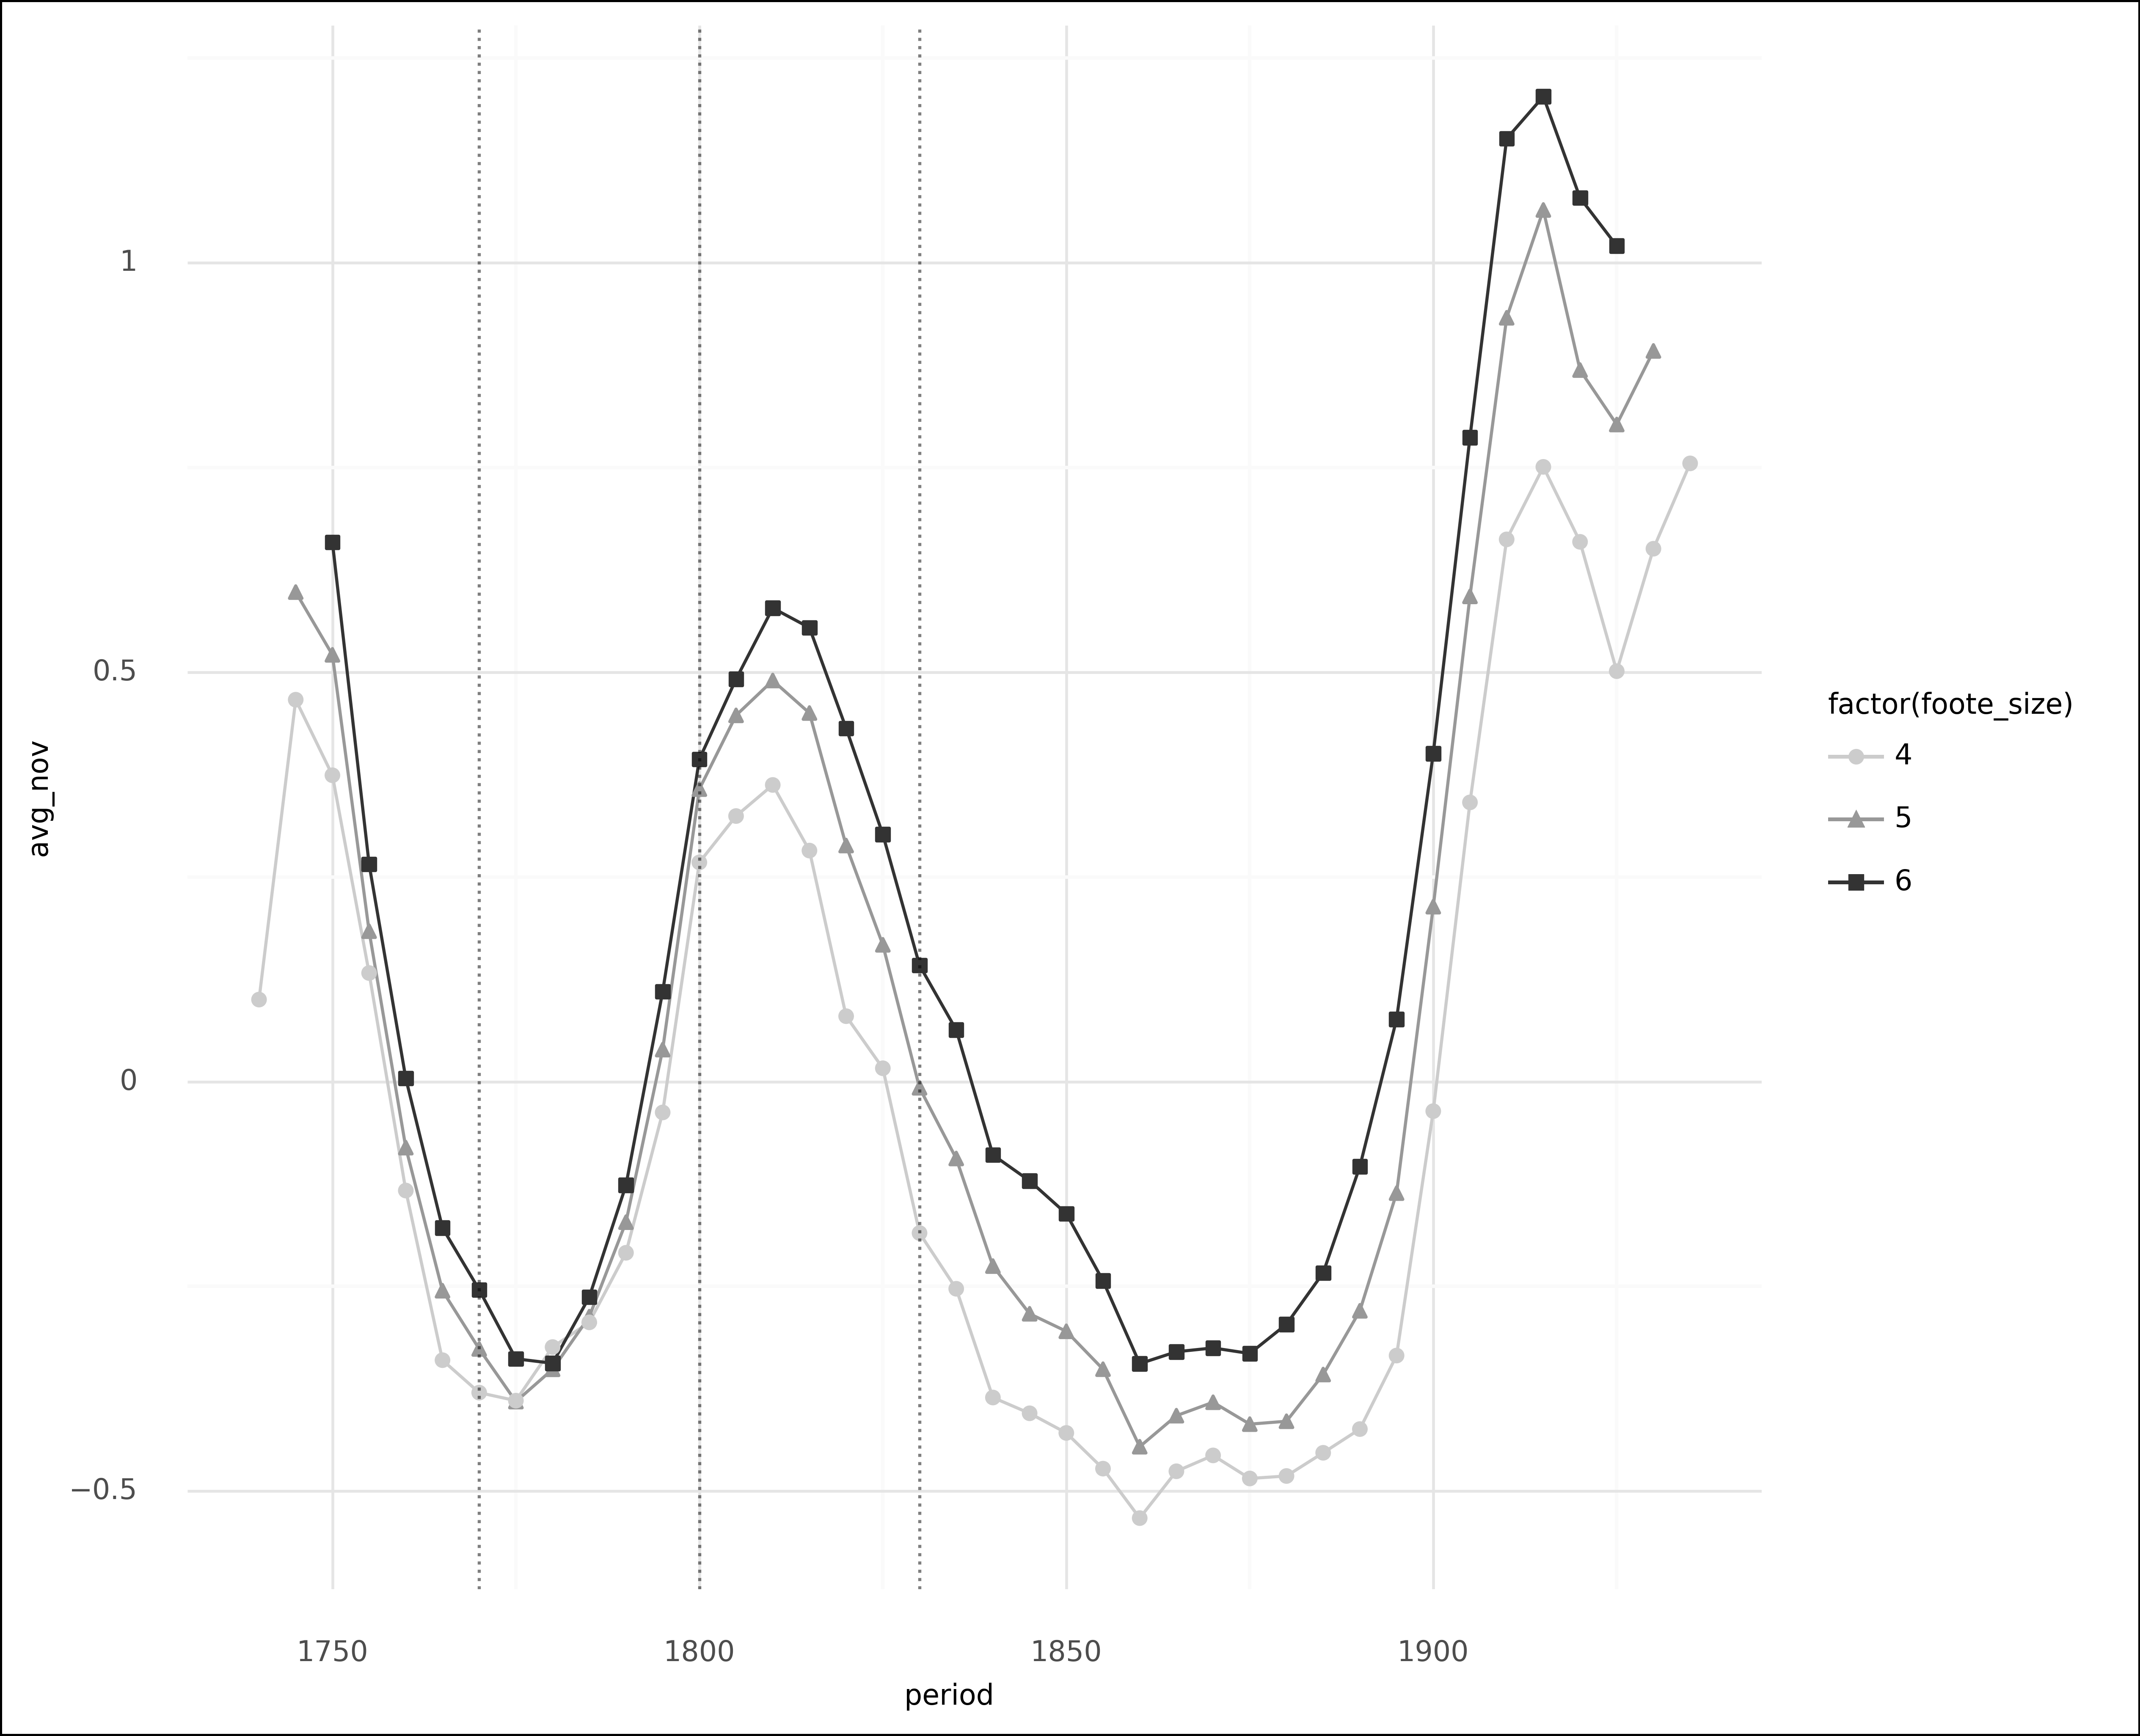

<ggplot: (416463162)>

In [343]:
plot_novelty_by_foote_size(rolling=1, p_peak=.05, min_peaks=2)#, words={'culture'})

# words used: 1


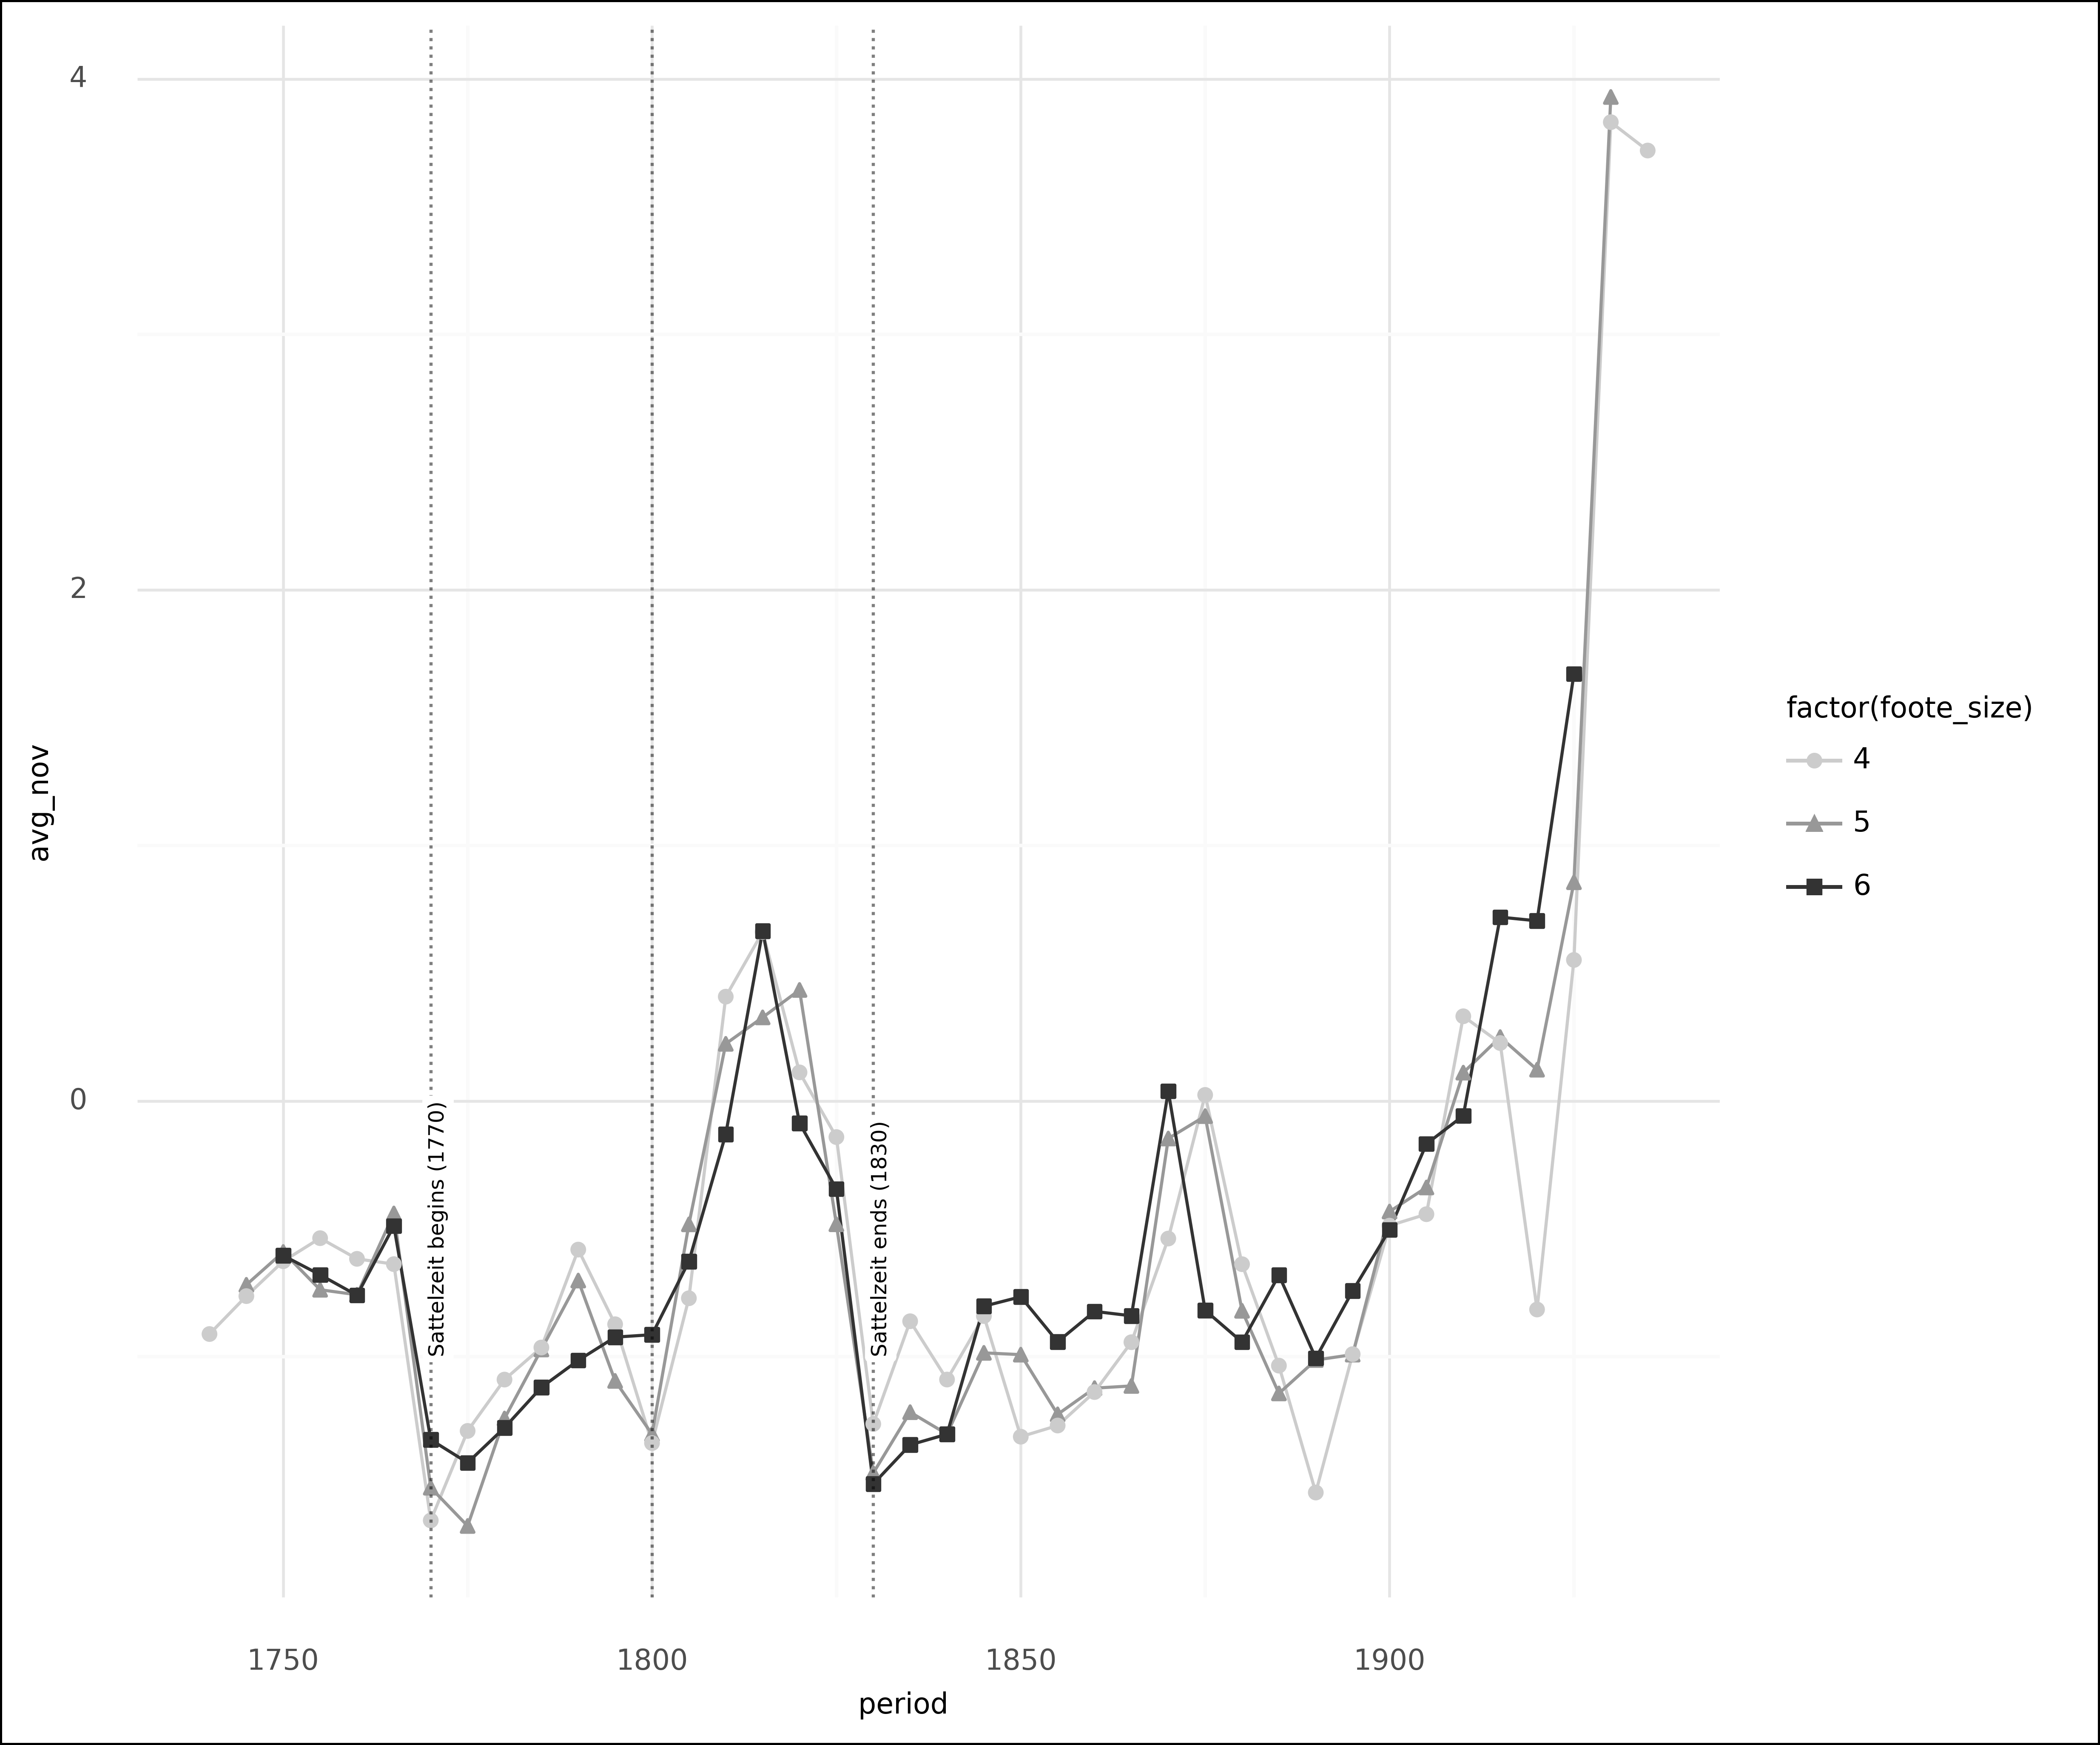

<ggplot: (428925263)>

In [346]:
plot_novelty_by_foote_size(rolling=1, words={'repetition'})

In [344]:
dfchangepoints=get_signif_novelty_scores(p_peak=.05, min_peaks=2).drop_duplicates('word',keep='first').sort_values('period')
dfchangepoints

,word,period,foote_novelty,p_peak,p_trough,foote_novelty_z,word_num_peaks
200053,world,1740,1.534415,0.00,1.0,-0.944271,2
73955,fog,1740,11.879192,0.01,1.0,2.795754,2
41104,contrast,1740,11.563777,0.00,1.0,2.681719,2
127982,page,1740,6.760617,0.00,1.0,0.945197,2
180431,tear,1740,12.115756,0.00,1.0,2.881280,2
...,...,...,...,...,...,...,...
114001,melody,1935,20.106138,0.00,1.0,5.770103,2
155401,rhythm,1935,17.883166,0.00,1.0,4.966415,2
187690,tree,1935,11.188779,0.00,1.0,2.546144,2
77113,frontispiece,1935,16.797819,0.00,1.0,4.574022,3


In [345]:
odfstr=pd.DataFrame([
    {'period':period, 'words':', '.join(grp.sort_values('foote_novelty_z',ascending=False).word)}
    for period,grp in sorted(dfchangepoints.groupby('period'))
])
printm(odfstr.to_markdown())

|    |   period | words                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|---:|---------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 |     1740 | mortar, rock, ditch, pressure, tear, fog, contrast, commencement, idol, interval, waste, village, turning, page, impression, afternoon, woman, age, morning, world                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
|  1 |     1745 | edge, thickness, chalk, angle, lime, height, horizon, dung, copper, axis, wheel, circulation, cheese, surface, size, square, base, circle, bottom, void, opening, centre, lake, temple, liquor, repose, glass, cloud, agony, lamp, painter, epistle, mix, flower, colour, breeze, top, plate, miracle, gate, breadth, tail, moon, perfidy, meat, credulity, level, valley, devotion, weight, scope, window, plan, story, river, picture, extent, water, husband, way, end, fortune, point, instance, place, confidence                                                                                                                                                                                                                                                                                                                                                                                               |
|  2 |     1750 | admiration, veil, price, toy, arch, fiend, gravel, angel, breath, skin, lark, bladder, opium, bottle, contentment, corpse, yard, wind, poem, adventure, parade, pulse, bible, production, patient, rose, belly, disorder, narrative, fever, shop, volume, perusal, conviction, experiment, system, scale, pamphlet, preface, anxiety, collection, poetry, sex, space, taste, affection, room, january, sunday, benefit, calling, spot, result, dinner, family, night, reader, mother, friend                                                                                                                                                                                                                                                                                                                                                                                                                         |
|  3 |     1755 | stomach, sake, efficacy, citizen, cure, corner, appetite, root, exchange, poultry, pot, solution, dose, infant, gift, publication, discussion, side, novel, edition, symptom, career, patriotism, food, effort, quotation, standing, saturday, artist, information, table, detail, week, conclusion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
|  4 |     1760 | lava, spreading, portrait, date, reply                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|  5 |     1765 | mode, mead, vest, consolation, succession, march, game, duchess, chair, queen                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|  6 |     1770 | judgement, motion, goal, independence, healing, debate                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|  7 |     1775 | magnitude, correspondence, impudence, blood                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|  8 |     1780 | reform, moving, fox, charcoal, vicinity, direction                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
|  9 |     1785 | gas, slave, adoption, trait, chancellor, test, cough, tension, exchequer, enthusiasm, feature, originality, suspicion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 10 |     1790 | case, decree, sort, intellect, sight, district, celebrity, oracle, province, process                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 11 |     1795 | list, stock, sum, rise, soil, atonement, landscape, lecture, market, rush, communication, exception, hesitation, question                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 12 |     1800 | sound, expense, sect, sitting, seat, grain, mist, demand, tenant, crop, institute, selection, sub, wheat, struggle, hay, correctness, fettle, lust, son, railing, isle, dress, substitute, frill, mailer, ostrich, suicide, flash, contradiction, kinsman, morrow, statement, aspect, gallery, characteristic, listening, saving, palace, quantity, quarter, proportion, island, supply, money, kind                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 13 |     1805 | hip, filter, mud, clash, conduit, hall, flood, rill, examiner, coon, whore, chase, newspaper, stall, fat, stimulus, manufacturing, shoulder, sill, lass, ass, conflict, junction, magistrate, mission, subsistence, selling, treatise, coast, actor, castle, guide, fashion, clock, employment, sea, wife                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 14 |     1810 | foil, sin, belt, slate, feat, fame, flock, fad, ruffian, welt, distress, missionary, mall, depression, minstrel, transport, loveliness, bark, singer, shaft, elf, urge, fir, pattern, sash, richness, shroud, suggestion, inquest, plea, spell, responsibility, steam, actress, currency, vicar, abbey, reduction, whistling, jurisdiction, peasant, renown, heresy, stuff, empress, extinction, sinner, shadow, legend, emblem, muse, injunction, apathy, sun, cost, amount                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| 15 |     1815 | fee, fun, loft, tilth, labourer, fleet, pall, sway, gazette, mercury, opera, presidency, patriot, darling, threshold, farce, hail, theatre, archdeacon, frolic, dialogue, geometry, fool, genius, break                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 16 |     1820 | strand, street, excitement, performance, grove, pantomime, intensity, comedy, park, slavery, meal, cell, livery, specie, maid, temperament, sunset, entertainment, truce, meadow, cat, tent, guest, intelligence, rod, applause, post, engagement, message, fish, arm, war, prince                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 17 |     1825 | regent, grass, daylight, turnip, culture, development, row, convoy, toil, query, rail, scrap, vegetation, basement, season, monday                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 18 |     1830 | cloth, linen, sowing, sport, merchant, straw, maker, dart, bookseller, troop, glance, bit                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| 19 |     1835 | element, bonus, op, trio, orchestra, organ, league, builder, cantata, boon, concert, ravine, locality, catholicism, bank, training, position, banker, heritage                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| 20 |     1840 | telegraph, assurance, band, cab, azure, contribution                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| 21 |     1845 | train, calf, gilt, strip, balm, envelope, melting, scandal, incarnation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 22 |     1850 | crystal, station, prelude, corn, pallor, significance, dating, cheque, application                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 23 |     1855 | choir, disc, buckle, devil, reproduction                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 24 |     1860 | domain, balcony, crown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 25 |     1865 | recital, thud, emulation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 26 |     1870 | gaiety, communion, restorer, rendering, morn, factor, evolution, cotton, minuet, royalty, criterion, spark, role, decade                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 27 |     1875 | staff, counterpoint, agency, bibliography, setting, road                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 28 |     1880 | frame, federation, contention, sig, firm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| 29 |     1885 | syllabus, cult, avenue, team, stigma, popery, cheapness, initiative, import, deity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 30 |     1890 | funk, duct, china, gunpowder, calmness                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| 31 |     1895 | depreciation, tsar, constable, chap, polo, dent, expansion, mourning, saviour                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| 32 |     1900 | sphere, bystander, reception, turf, freehold, scotch, kaiser, hotel, asset, ally, purity, outlook, texture, fountain, residence, simile, mysticism, razor, delivery, penitence, steeplechase, combustion, fatigue, propagation, photograph, regularity, cottage, sickness, king                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 33 |     1905 | proof, treatment, hem, car, vehicle, ger, tablet, cup, complexion, safety, trial, comfort, aerial, irritation, cylinder, unrest, milk, exhaustion, tube, ex, handicap, mixture, toll, oxygen, detachment, roughness, planning, throat, representation, lotus, ore, perfection, injury, forgiveness, latitude, corporation, bath, reproach, prophecy, prophet, choice, reputation, duke, trouble, spirit                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| 34 |     1910 | bust, fur, request, hair, acid, coat, cam, germ, waist, refinement, sunbeam, manufacturer, cream, patent, shade, economy, fragrance, lustre, platinum, fulness, overcoat, decay, perfume, vogue, salad, salt, contour, sultan, dish, bloom, engine, bee, freshness, lace, salon, butter, metal, fuel, bout, ivory, pinch, con, millinery, coach, durability, kit, tweed, catalogue, warmth, ribbon, mat, gent, satin, wad, cleanliness, righteousness, beet, ban, delicacy, equipment, ventilating, model, hypothesis, smoothness, saddle, emerald, efficiency, shirt, grit, bus, oak, range, structure, ad, tavern, ling, measurement, dot, visitation, publicity, beak, hose, elegance, tract, idiom, neck, cap, canvas, cart, shopping, sketch, speed, quality, earl, pair, climate, mouth, horse, eloquence, excellence, peace, grant, vanity, charity, astonishment, running, service, health, lady, appearance |
| 35 |     1915 | revue, nave, navy, toe, jumper, tin, garment, film, wool, panel, gown, appointment, bat, imitation, tar, seal, frock, puff, skirt, chancel, width, powder, kennel, tan, cologne, smartness, fabric, grade, heel, perspiration, collar, tower, lather, knitting, flannel, vat, bot, heather, grate, borough, protection, abbot, dilemma, clothing, flying, treaty, torrent, recording, tot, axe, multiplication, preparation, stone, par, ledge, bishop, ape, engineering, shape, satisfaction, pitcher, manor, pathway, hospital, plank, piety, pain, requirement, design, chin, obligation, spring, indulgence, recovery, traffic, grace, variety, religion, conference, policy, humour, aid, body, approach, court, travel, length, nation, happiness                                                                                                                                                              |
| 36 |     1920 | wit, bid, eve, tee, cork, arithmetic, sunshine, architect, cape, saloon, screen, player, gear, tutor, race, lilt, pension, background, atlas, fern, grammar, revelation, steering, conversion, asylum, surveyor, cur, terrier, rouge, ref, dog, engineer, shock, vocabulary, swimming, bidding, vault, gospel, floor, dancing, hole, ball, ministry, dread, ornament, county, hive, appendix, hat, department, inscription, wall, shot, chapel, vet, property, countenance, welfare, preservation, material, measure, distance, lord                                                                                                                                                                                                                                                                                                                                                                                 |
| 37 |     1925 | tie, broadcast, star, ensemble, foundation, lid, lamb, geography, winner, chemistry, harvest, ant, tote, omnibus, vita, pal, mathematics, breast, physics, flight, meditation, tit, ale, inspector, marble, bobby, resignation, sire, nit, prayer, apparel, kitchen, ion, murmur, removal, contract, salary, accident, classification, university, fare, tine, shore, force, murder, reformation, origin, academy, meeting, author                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 38 |     1930 | harmony, pool, teacher, bar, pitch, score, quiver, cradle, tempo, finale, diploma, gable, butt, lute, doc, glee, shepherd, resident, cuckoo, suspense, slumber, repetition, rally, tuition, thanksgiving, baton, instruction, execution, windmill, version, tow, cellar, examination, blessing, quest, coward, vision, hack, registration, regency, farmer, heaven, crime, resolution, cathedral, stillness, lip, dame, bill, scoring, signature, interpretation, congregation, hut, mate, god, awe, integrity, glory, party, voice, prose, professor, proposal, council, study, creature, board, society, manner                                                                                                                                                                                                                                                                                                    |
| 39 |     1935 | suite, bass, tenor, chorus, baritone, violin, song, anthem, melody, utterance, chord, harp, dictionary, hymn, rhythm, overture, snipe, symphony, growth, precision, frontispiece, tone, surplus, teaching, settlement, kid, composer, facility, carrier, chamber, assortment, composition, peak, employer, elephant, tile, char, expression, passage, insect, pa, taxation, apple, capital, ear, draft, compass, bargain, practice, credit, rat, philosophy, tree, phrase, translation, bell, college, animal, hearing, festival, damage, law, grandeur, report, arrangement, pen, duty, form, contrary, school                                                                                                                                                                                                                                                                                                      |

## Plotting individual words

In [146]:
def plot_novelty_words(words,**kwargs):
    inpd=dict(
        y='foote_novelty_z',
        words=words,
        color='word',
        group='word',
        shape='word',
        colorlab='Word',
        shapelab='Word',
        sizelab='Statistically significant',
        title='Novelty scores for key words',
        ylab='Foote Novelty score',
        size='is_signif',
        vnum='v19',
        use_ylim=False,
        add_median=True,
        max_p_peak=0.0,
        min_foote_size=5,
        max_foote_size=5,
        showdata=False,
        nudge_x=2,
        logy=False,
        ylim0=0,
        ylim1=10,
        xlim0=1745,
        xlim1=1870,
        rolling=2,
        ymin=.1,
        label_words=True,
        show_period_labels=True,
        nudge_label_y=0.25,
        save=True
    )
    return plot_novelty(**{**inpd, **kwargs})


In [ ]:
# plot_novelty_words('station,value,commerce,growth,culture,slave,slavery,god,time,december')
plot_novelty_words('station,value,slave,demand,interest,circulation,improvement')